In [ ]:
%run preprocessing_3.ipynb

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime, timedelta

y = df['phase_encoded']

x = df.drop(['phase', 'phase_encoded', 'current_date', 'last_period_start_date', 'LengthofLutealPhase', 'EstimatedDayofOvulation'], axis=1)

y = y[x.index]

In [3]:
print(x)

      LengthofCycle  LengthofMenses  MeanMensesScore  cycle_day
0                29               2         2.000000          6
1                27               2         2.000000         19
2                29               2         2.000000         28
3                27               2         2.400000         14
4                28               2         2.200000         10
...             ...             ...              ...        ...
1660             29              15         1.875000          7
1661             28               5         1.833333         18
1662             28               5         1.800000         17
1663             40               5         2.000000          0
1664             24               5         1.879427         13

[1665 rows x 4 columns]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [5]:
model_xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
model_xgb.fit(x_train, y_train)

y_pred_xgb = model_xgb.predict(x_test)

report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Classification Report:\n", report_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

XGBoost Classification Report:
               precision    recall  f1-score   support

  Follicular       0.99      0.99      0.99       104
      Luteal       0.99      0.97      0.98       116
   Menstrual       1.00      1.00      1.00        66
   Ovulation       0.92      0.98      0.95        47

    accuracy                           0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333

XGBoost Accuracy: 0.9819819819819819


In [6]:
from sklearn.metrics import log_loss

# Predict probabilities on the test set
y_pred_prob = model_xgb.predict_proba(x_test)

# Compute the multiclass log loss (mlogloss)
mlogloss_value = log_loss(y_test, y_pred_prob)

# Print the log loss value
print(f"Multiclass Log Loss (mlogloss): {mlogloss_value:.4f}")

Multiclass Log Loss (mlogloss): 0.0624


In [7]:
# check for overfitting
train_accuracy = accuracy_score(y_train, model_xgb.predict(x_train))
test_accuracy = accuracy_score(y_test, model_xgb.predict(x_test))
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 1.0
Test Accuracy: 0.9819819819819819


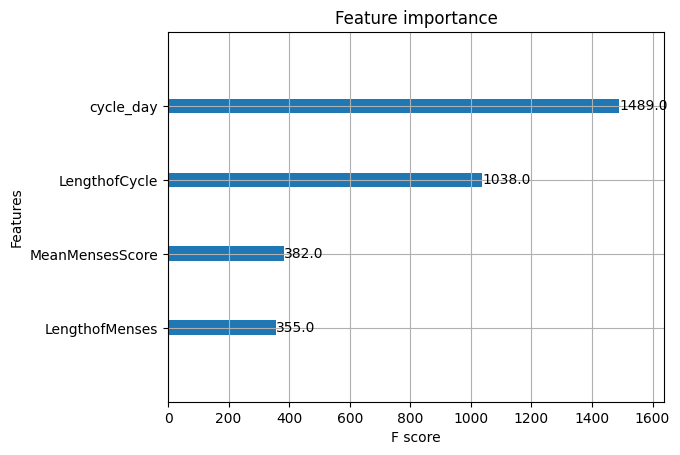

           Feature  Importance
3        cycle_day    0.631706
0    LengthofCycle    0.233182
1   LengthofMenses    0.112186
2  MeanMensesScore    0.022926


In [8]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(model_xgb)
plt.show()

# Get feature importances
importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

In [9]:
# SMOTE METHOD
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=41)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

model_xgb.fit(x_train_smote, y_train_smote)

y_pred_xgb = model_xgb.predict(x_test)

report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Classification Report after SMOTE:\n", report_xgb)
print(f"XGBoost Accuracy after SMOTE: {accuracy_xgb}")

XGBoost Classification Report after SMOTE:
               precision    recall  f1-score   support

  Follicular       0.99      0.97      0.98       104
      Luteal       0.99      0.96      0.97       116
   Menstrual       0.99      1.00      0.99        66
   Ovulation       0.88      0.98      0.93        47

    accuracy                           0.97       333
   macro avg       0.96      0.98      0.97       333
weighted avg       0.97      0.97      0.97       333

XGBoost Accuracy after SMOTE: 0.972972972972973


In [10]:
# Stratified K-fold cross validation Method
from sklearn.model_selection import StratifiedKFold

# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracies = []
reports = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE on the training set
    smote = SMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Train the model
    model_xgb.fit(x_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model_xgb.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    accuracies.append(accuracy)
    reports.append(report)

# Print average accuracy and reports
print(f"Average Accuracy: {sum(accuracies) / len(accuracies)}")
for i, report in enumerate(reports):
    print(f"\nClassification Report for Fold {i+1}:\n{report}")

Average Accuracy: 0.9861861861861861

Classification Report for Fold 1:
              precision    recall  f1-score   support

  Follicular       0.97      1.00      0.99        99
      Luteal       1.00      1.00      1.00       123
   Menstrual       1.00      0.98      0.99        62
   Ovulation       1.00      0.96      0.98        49

    accuracy                           0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333


Classification Report for Fold 2:
              precision    recall  f1-score   support

  Follicular       0.99      0.98      0.98        99
      Luteal       1.00      0.98      0.99       122
   Menstrual       0.98      1.00      0.99        62
   Ovulation       0.96      1.00      0.98        50

    accuracy                           0.99       333
   macro avg       0.98      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333


Classification Report 

In [11]:
# FINDING HYPERTUNING PARAMETERS
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.1, 1]
}
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [12]:
best_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
final_model = XGBClassifier(**best_params, eval_metric='mlogloss')
final_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid_search.fit(x_train_smote, y_train_smote)

# Step 3: Use the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
final_model = XGBClassifier(**best_params, eval_metric="mlogloss")

# Step 4: Train the XGBoost model with SMOTE-applied data and best hyperparameters
final_model.fit(x_train_smote, y_train_smote)

# Step 5: Make predictions and evaluate the model on test data
y_pred_final = final_model.predict(x_test)

# Step 6: Print classification report and accuracy for the final model
report_final = classification_report(y_test, y_pred_final, target_names=label_encoder.classes_)
accuracy_final = accuracy_score(y_test, y_pred_final)
print("Final XGBoost Classification Report after SMOTE and Hyperparameter Tuning:\n", report_final)
print(f"Final XGBoost Test Accuracy: {accuracy_final}")


Final XGBoost Classification Report after SMOTE and Hyperparameter Tuning:
               precision    recall  f1-score   support

  Follicular       1.00      0.99      0.99        98
      Luteal       1.00      0.99      1.00       123
   Menstrual       1.00      1.00      1.00        63
   Ovulation       0.96      1.00      0.98        49

    accuracy                           0.99       333
   macro avg       0.99      1.00      0.99       333
weighted avg       0.99      0.99      0.99       333

Final XGBoost Test Accuracy: 0.993993993993994


In [14]:
print(x.columns)

Index(['LengthofCycle', 'LengthofMenses', 'MeanMensesScore', 'cycle_day'], dtype='object')


In [15]:
import time

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Updated dietary recommendations based on phases
menstrual_tips = {
    "menstrual": {
        "veg": {
            "recommended": ["Spinach", "Broccoli", "Sweet Potatoes", "Beetroot"],
            "foods_to_avoid": ["Caffeine", "Processed foods", "Sugary snacks", "Salty foods"]
        },
        "non_veg": {
            "recommended": ["Chicken", "Salmon", "Eggs"],
            "foods_to_avoid": ["Caffeine", "Processed foods", "Sugary snacks", "Salty foods"]
        },
        "vegan": {
            "recommended": ["Kale", "Tofu", "Quinoa", "Avocado"],
            "foods_to_avoid": ["Caffeine", "Processed foods", "Sugary snacks", "Salty foods"]
        },
        "hydration": "Stay hydrated by drinking plenty of water and herbal teas like ginger or chamomile to ease cramps."
    },
    "follicular": {
        "veg": {
            "recommended": ["Lentils", "Zucchini", "Bell Peppers", "Pumpkin Seeds"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"]
        },
        "non_veg": {
            "recommended": ["Turkey", "Tuna", "Lean Beef"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"]
        },
        "vegan": {
            "recommended": ["Chia Seeds", "Oats", "Flaxseeds", "Almonds"],
            "foods_to_avoid": ["Refined carbs", "Excessive sugar", "Heavy fats"]
        },
        "hydration": "Focus on hydrating with electrolyte-rich drinks such as coconut water and green juices."
    },
    "ovulation": {
        "veg": {
            "recommended": ["Asparagus", "Brussels Sprouts", "Peas"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"]
        },
        "non_veg": {
            "recommended": ["Chicken", "Shrimp", "Eggs"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"]
        },
        "vegan": {
            "recommended": ["Hemp Seeds", "Tempeh", "Chickpeas"],
            "foods_to_avoid": ["Processed foods", "Fried foods", "Caffeine"]
        },
        "hydration": "Drink plenty of water and consider adding fruit-infused water to boost hydration during this phase."
    },
    "luteal": {
        "veg": {
            "recommended": ["Carrots", "Sweet Potatoes", "Cauliflower"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"]
        },
        "non_veg": {
            "recommended": ["Lamb", "Salmon", "Turkey"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"]
        },
        "vegan": {
            "recommended": ["Brown Rice", "Walnuts", "Chia Seeds"],
            "foods_to_avoid": ["Excess salt", "Alcohol", "Caffeine", "Greasy foods"]
        },
        "hydration": "Herbal teas like peppermint or chamomile can help reduce bloating. Continue with adequate water intake."
    }
}

phase_mapping = {
    0: "follicular",
    1: "luteal",
    2: "menstrual",
    3: "ovulation"
}

def get_tips(phase, diet):
    """Get dietary tips based on the phase and diet type."""
    if phase in menstrual_tips and diet in menstrual_tips[phase]:
        return {
            "recommendations": menstrual_tips[phase][diet]["recommended"],
            "hydration": menstrual_tips[phase]["hydration"],
            "foods_to_avoid": menstrual_tips[phase][diet]["foods_to_avoid"]
        }
    return None

def plot_phase_visualization(predicted_df, days_since_last_period):
    """Visualize the predicted phases across the menstrual cycle."""
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df['Day'], predicted_df['Predicted Phase'], marker='o', linestyle='-', markersize=8, color='b')
    plt.axvline(x=days_since_last_period, color='r', linestyle='--', label='Today')  # Highlight current day
    plt.title('Predicted Phases Across the Menstrual Cycle')
    plt.xlabel('Day of Cycle')
    plt.ylabel('Predicted Phase')
    plt.xticks(np.arange(1, len(predicted_df) + 1, 1))  # Set x-ticks from 1 to cycle_length
    plt.grid(True)
    plt.legend()
    plt.show()

def predict_and_visualize_phases(cycle_length, menses_length, mean_menses_score, last_period_start_date, model):
    """Predict menstrual phases and visualize the predictions."""
    
    # Create data for each day in the cycle
    all_days = pd.DataFrame({
        'LengthofCycle': [cycle_length] * cycle_length,
        'LengthofMenses': [menses_length] * cycle_length,
        'MeanMensesScore': [mean_menses_score] * cycle_length,
        'cycle_day': np.arange(cycle_length)  # Days from 0 to cycle_length - 1
    })

    predicted_phases = model.predict(all_days)

    predicted_df = pd.DataFrame({
        'Day': np.arange(1, cycle_length + 1),
        'Predicted Phase': [phase_mapping[pred] for pred in predicted_phases]
    })

    current_date = pd.Timestamp(datetime.today())
    days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length

    current_day_data = pd.DataFrame({
        'LengthofCycle': [cycle_length],
        'LengthofMenses': [menses_length],
        'MeanMensesScore': [mean_menses_score],
        'cycle_day': [days_since_last_period]  # Keep this as is for current day data
    })
    
    predicted_phase_today = model.predict(current_day_data)[0]
    
    predicted_phase_today_name = phase_mapping[predicted_phase_today]

    plot_phase_visualization(predicted_df, days_since_last_period)  # Pass the correct day
    
    return predicted_df, predicted_phase_today_name


def get_diet_from_choice(choice):
    if choice == 1:
        return "non_veg"
    elif choice == 2:
        return "veg"
    elif choice == 3:
        return "vegan"
    return None    

def combined_prediction_and_recommendation(cycle_length, menses_length, mean_menses_score, last_period_start_date, model_xgb):
    """Combine prediction and dietary recommendations."""
    
    predicted_df, predicted_phase_today = predict_and_visualize_phases(cycle_length, menses_length, mean_menses_score, last_period_start_date, model_xgb)

    # Get diet choice from user
    print("\nToday's predicted phase is:", predicted_phase_today)
    print("\nChoose your diet:")
    print("1. Non-veg")
    print("2. Veg")
    print("3. Vegan")

    try:
        diet_choice = int(input("Enter your choice (1/2/3): "))
        diet = get_diet_from_choice(diet_choice)
        
        if diet:
            tips = get_tips(predicted_phase_today.lower(), diet)
            
            if tips:
                recommendations = tips["recommendations"]
                hydration = tips["hydration"]
                foods_to_avoid = tips["foods_to_avoid"]

                print(f"\nRecommended foods for the {predicted_phase_today} phase (Diet: {diet}):")
                for food in recommendations:
                    print(f"- {food}")

                print(f"\nHydration tip for the {predicted_phase_today} phase:")
                print(hydration)

                print(f"\nFoods to avoid during the {predicted_phase_today} phase:")
                for food in foods_to_avoid:
                    print(f"- {food}")
            else:
                print("Invalid diet choice for this phase. Please try again.")
        else:
            print("Invalid choice! Please select 1 for Non-veg, 2 for Veg, or 3 for Vegan.")
    except ValueError:
        print("Invalid input. Please enter a valid number (1/2/3).")

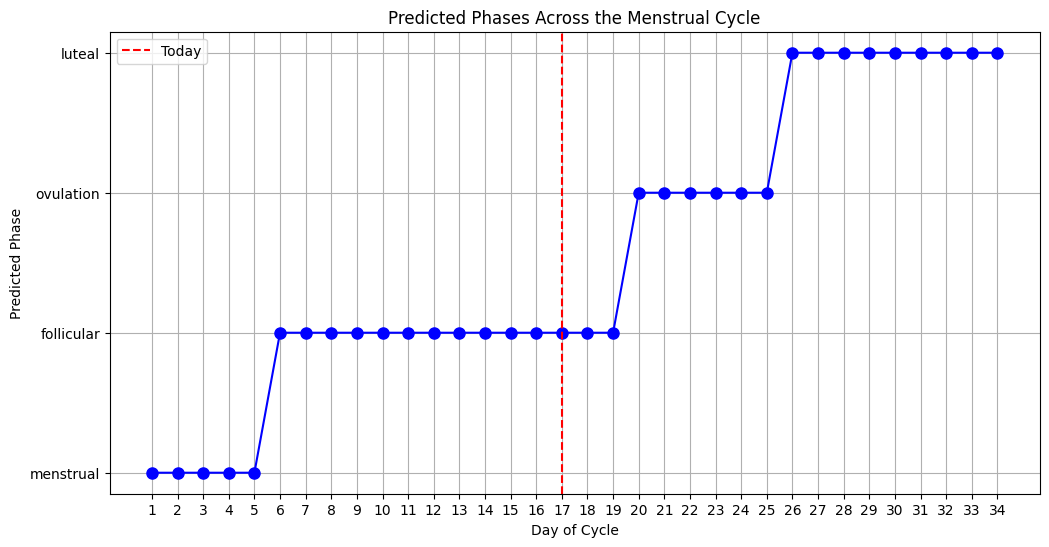


Today's predicted phase is: follicular

Choose your diet:
1. Non-veg
2. Veg
3. Vegan

Recommended foods for the follicular phase (Diet: veg):
- Lentils
- Zucchini
- Bell Peppers
- Pumpkin Seeds

Hydration tip for the follicular phase:
Focus on hydrating with electrolyte-rich drinks such as coconut water and green juices.

Foods to avoid during the follicular phase:
- Refined carbs
- Excessive sugar
- Heavy fats


In [17]:
cycle_length = 34
menses_length = 5
mean_menses_score = 2 # ranges from 1-3 
last_period_start_date = datetime.today() - timedelta(days=17)
model = model_xgb

combined_prediction_and_recommendation(cycle_length, menses_length, mean_menses_score, last_period_start_date, model)

In [18]:
current_date = pd.Timestamp(datetime.today())
days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length

current_day_data = pd.DataFrame({
   'LengthofCycle': [cycle_length],
   'LengthofMenses': [menses_length],
   'MeanMensesScore': [mean_menses_score],
   'cycle_day': [days_since_last_period]  # Keep this as is for current day data
})
    
# Measure latency
start_time = time.time()
    
predicted_phase_today = model_xgb.predict(current_day_data)[0]
    
end_time = time.time()

latency = end_time - start_time
print(f"Prediction took {latency:.4f} seconds")

Prediction took 0.0048 seconds


In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model on the training data
rf.fit(x_train, y_train)

# Measure latency
start_time = time.time()
# Predict on the test set
y_pred = rf.predict(x_test)

end_time = time.time()

latency = end_time - start_time

# Evaluate the model
print(classification_report(y_test, y_pred))

print(f"Prediction took {latency:.4f} seconds")

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        98
           1       0.98      0.98      0.98       123
           2       1.00      1.00      1.00        63
           3       0.92      0.92      0.92        49

    accuracy                           0.98       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.98      0.98      0.98       333

Prediction took 0.0200 seconds


In [20]:
from sklearn.svm import SVC

# Create a kernel SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# Train the model on the training data
svm_model.fit(x_train, y_train)

# Measure latency
start_time = time.time()
# Predict on the test set
y_pred = svm_model.predict(x_test)

end_time = time.time()

latency = end_time - start_time

# Evaluate the model
print(classification_report(y_test, y_pred))

print(f"Prediction took {latency:.4f} seconds")

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        98
           1       1.00      1.00      1.00       123
           2       0.95      1.00      0.98        63
           3       1.00      0.98      0.99        49

    accuracy                           0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333

Prediction took 0.0382 seconds


In [21]:
train_accuracy = accuracy_score(y_train, svm_model.predict(x_train))
test_accuracy = accuracy_score(y_test, svm_model.predict(x_test))
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9804804804804805
Test Accuracy: 0.987987987987988


In [22]:
def gui_predict_phases(cycle_length, menses_length, mean_menses_score, last_period_start_date, model):
    """Predict menstrual phases and visualize the predictions."""
    
    # Create data for each day in the cycle
    all_days = pd.DataFrame({
        'LengthofCycle': [cycle_length] * cycle_length,
        'LengthofMenses': [menses_length] * cycle_length,
        'MeanMensesScore': [mean_menses_score] * cycle_length,
        'cycle_day': np.arange(cycle_length)  # Days from 0 to cycle_length - 1
    })

    predicted_phases = model.predict(all_days)

    predicted_df = pd.DataFrame({
        'Day': np.arange(1, cycle_length + 1),
        'Predicted Phase': [phase_mapping[pred] for pred in predicted_phases]
    })

    current_date = pd.Timestamp(datetime.today())
    days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length

    current_day_data = pd.DataFrame({
        'LengthofCycle': [cycle_length],
        'LengthofMenses': [menses_length],
        'MeanMensesScore': [mean_menses_score],
        'cycle_day': [days_since_last_period]  # Keep this as is for current day data
    })
    
    predicted_phase_today = model.predict(current_day_data)[0]
    predicted_phase_today_name = phase_mapping[predicted_phase_today]
    
    return predicted_df, predicted_phase_today_name


def gui_get_diet_from_choice(choice):
    if choice == "Non-veg":
        return "non_veg"
    elif choice == "Veg":
        return "veg"
    elif choice == "Vegan":
        return "vegan"
    return None

In [24]:
# import tkinter as tk
# from tkinter import messagebox, font
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# import pandas as pd
# from datetime import datetime
# import numpy as np
# import matplotlib.pyplot as plt

# class MenstrualCycleApp:
#     def __init__(self, root):
#         self.root = root
#         self.root.title("Cycle Diet Helper")
#         self.root.configure(bg='#130d1a')  # Set background color to #130d1a
#         self.create_first_window()

#     def create_first_window(self):
#         self.clear_window()
#         self.custom_font = font.Font(family="Helvetica", size=12, weight="bold")

#         # Frame to center align content
#         frame = tk.Frame(self.root, bg='#130d1a')
#         frame.pack(expand=True, fill=tk.BOTH)

#         tk.Label(frame, text="Enter your Name:", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
#         self.name_entry = tk.Entry(frame)
#         self.name_entry.pack(pady=10)

#         tk.Label(frame, text="Enter your Age:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
#         self.age_entry = tk.Entry(frame)
#         self.age_entry.pack(pady=10)

#         tk.Label(frame, text="How are you feeling today?", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
#         self.mood_entry = tk.Entry(frame)
#         self.mood_entry.pack(pady=10)

#         tk.Button(frame, text="Next", font=self.custom_font, bg="#5cd9ff", command=self.goto_second_window).pack(pady=20)

#     def goto_second_window(self):
#         name = self.name_entry.get()
#         age = self.age_entry.get()
#         mood = self.mood_entry.get()

#         if name and age.isdigit() and mood:
#             self.name = name
#             self.age = int(age)
#             self.mood = mood
#             self.clear_window()

#             frame = tk.Frame(self.root, bg='#130d1a')
#             frame.pack(expand=True, fill=tk.BOTH)

#             tk.Label(frame, text=f"I know you're going through a tiring phase, {name}.", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
#             tk.Label(frame, text="But I'm here to help you with some tips to make your day better! 😊", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)

#             tk.Label(frame, text="Enter your Cycle Length:", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
#             self.cycle_length_entry = tk.Entry(frame)
#             self.cycle_length_entry.pack(pady=10)

#             tk.Label(frame, text="Enter your Menses Length:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
#             self.menses_length_entry = tk.Entry(frame)
#             self.menses_length_entry.pack(pady=10)

#             tk.Label(frame, text="Enter Mean Menses Score (1-3):", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
#             self.menses_score_entry = tk.Entry(frame)
#             self.menses_score_entry.pack(pady=10)

#             tk.Label(frame, text="Enter Last Period Start Date (YYYY-MM-DD):", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
#             self.last_period_entry = tk.Entry(frame)
#             self.last_period_entry.pack(pady=10)

#             tk.Label(frame, text="Select Your Diet Preference:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
#             self.diet_choice = tk.StringVar(self.root)
#             self.diet_choice.set("Select")  # Default value
#             tk.OptionMenu(frame, self.diet_choice, "Non-veg", "Veg", "Vegan").pack(pady=10)

#             tk.Button(frame, text="Get Diet Tips", font=self.custom_font, bg="#0af0d9", command=self.show_diet_tips).pack(pady=20)

#         else:
#             messagebox.showerror("Input Error", "Please enter valid name, age, and mood.")

#     def show_diet_tips(self):
#         try:
#             cycle_length = int(self.cycle_length_entry.get())
#             menses_length = int(self.menses_length_entry.get())
#             mean_menses_score = int(self.menses_score_entry.get())
#             last_period_start_date = self.last_period_entry.get()

#             # Convert diet selection to matching diet key
#             diet_type = gui_get_diet_from_choice(self.diet_choice.get())
#             if not diet_type:
#                 messagebox.showerror("Input Error", "Please select a valid diet preference.")
#                 return

#             # Predict phase (Ensure you have a defined `model_xgb` for this)
#             predicted_df, current_phase = gui_predict_phases(cycle_length, menses_length, mean_menses_score,
#                                                              last_period_start_date, model_xgb)

#             # Fetch tips based on the current phase and diet
#             tips = get_tips(current_phase, diet_type)

#             if tips:
#                 # Get the number of days since last period
#                 current_date = pd.Timestamp(datetime.today())
#                 days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length
                
#                 # Display the diet recommendations and plot
#                 self.display_diet_recommendations(tips, current_phase, predicted_df, days_since_last_period)
#             else:
#                 messagebox.showerror("Diet Error", "No tips available for the selected diet and phase.")

#         except ValueError:
#             messagebox.showerror("Input Error", "Please enter valid numeric values for cycle and menses lengths and menses score.")

#     def display_diet_recommendations(self, tips, current_phase, predicted_df, days_since_last_period):
#         self.clear_window()
        
#         frame = tk.Frame(self.root, bg='#130d1a')
#         frame.pack(expand=True, fill=tk.BOTH)

#         # Display the phase and diet recommendations
#         tk.Label(frame, text=f"Today's predicted phase is: {current_phase}", font=self.custom_font,
#                  fg="#0af0d9", bg='#130d1a').pack(pady=10)
#         tk.Label(frame, text="Here are your Dietary Recommendations:", font=self.custom_font,
#                  fg="#5cd9ff", bg='#130d1a').pack(pady=10)

#         tk.Label(frame, text="Recommended Foods:", font=self.custom_font,
#                  fg="#f55fa2", bg='#130d1a').pack(pady=5)
#         tk.Label(frame, text=", ".join(tips["recommendations"]), font=self.custom_font,
#                  fg="white", bg='#130d1a').pack(pady=5)

#         tk.Label(frame, text="Foods to Avoid:", font=self.custom_font,
#                  fg="#f55fa2", bg='#130d1a').pack(pady=5)
#         tk.Label(frame, text=", ".join(tips["foods_to_avoid"]), font=self.custom_font,
#                  fg="white", bg='#130d1a').pack(pady=5)

#         tk.Label(frame, text="Hydration Tips:", font=self.custom_font,
#                  fg="#f55fa2", bg='#130d1a').pack(pady=5)
#         tk.Label(frame, text=tips["hydration"], font=self.custom_font,
#                  fg="white", bg='#130d1a').pack(pady=5)

#         # Plot the menstrual phase visualization
#         self.plot_phase_visualization(predicted_df, days_since_last_period)

#         # Back button to return to the first window
#         tk.Button(frame, text="Back", font=self.custom_font,
#                   bg="#0af0d9", command=self.create_first_window).pack(pady=20)

#     def plot_phase_visualization(self, predicted_df, days_since_last_period):
#         """Visualize the predicted phases across the menstrual cycle."""
        
#         fig , ax = plt.subplots(figsize=(10 , 6))

#          # Plot the predicted phases 
#         ax.plot(predicted_df['Day'], predicted_df['Predicted Phase'], marker='o', linestyle='-', markersize=8,
#                  color='b')

#          # Highlight the current day 
#         ax.axvline(x=days_since_last_period + 1 , color='r', linestyle='--', label='Today')

#          # Set the plot title and labels 
#         ax.set_title('Predicted Phases Across the Menstrual Cycle')
#         ax.set_xlabel('Day of Cycle')
#         ax.set_ylabel('Predicted Phase')

#          # Customize x-ticks to match the cycle length 
#         ax.set_xticks(np.arange(1,len(predicted_df) + 1 , 1))

#          # Add grid and legend 
#         ax.grid(True) 
#         ax.legend()

#          # Embed the plot in Tkinter window using FigureCanvasTkAgg 
#         canvas = FigureCanvasTkAgg(fig , master=self.root)  
#         canvas.draw() 
#         canvas.get_tk_widget().pack(pady=10)  # Add the plot widget to the window 

#     def clear_window(self):
#         for widget in self.root.winfo_children():
#             widget.destroy()

# # Main Program Execution 
# if __name__ == "__main__":
#     root = tk.Tk()
#     app = MenstrualCycleApp(root) 
#     root.mainloop()


In [52]:
import tkinter as tk
from tkinter import messagebox, font
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

class MenstrualCycleApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Cycle Diet Helper")
        self.root.configure(bg='#130d1a')  # Set background color to #130d1a
        self.create_first_window()

    def create_first_window(self):
        self.clear_window()
        self.custom_font = font.Font(family="Helvetica", size=12, weight="bold")

        # Frame to center align content
        frame = tk.Frame(self.root, bg='#130d1a')
        frame.pack(expand=True, fill=tk.BOTH)

        tk.Label(frame, text="Enter your Name:", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
        self.name_entry = tk.Entry(frame)
        self.name_entry.pack(pady=10)

        tk.Label(frame, text="Enter your Age:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
        self.age_entry = tk.Entry(frame)
        self.age_entry.pack(pady=10)

        tk.Label(frame, text="How are you feeling today?", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
        self.mood_entry = tk.Entry(frame)
        self.mood_entry.pack(pady=10)

        tk.Button(frame, text="Next", font=self.custom_font, bg="#5cd9ff", command=self.goto_second_window).pack(pady=20)

    def goto_second_window(self):
        name = self.name_entry.get()
        age = self.age_entry.get()
        mood = self.mood_entry.get()

        if name and age.isdigit() and mood:
            self.name = name
            self.age = int(age)
            self.mood = mood
            self.clear_window()

            frame = tk.Frame(self.root, bg='#130d1a')
            frame.pack(expand=True, fill=tk.BOTH)

            tk.Label(frame, text=f"I know you're going through a tiring phase, {name}.", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            tk.Label(frame, text="But I'm here to help you with some tips to make your day better! 😊", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)

            tk.Label(frame, text="Enter your Cycle Length:", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
            self.cycle_length_entry = tk.Entry(frame)
            self.cycle_length_entry.pack(pady=10)

            tk.Label(frame, text="Enter your Menses Length:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            self.menses_length_entry = tk.Entry(frame)
            self.menses_length_entry.pack(pady=10)

            tk.Label(frame, text="Enter Mean Menses Score (1-3):", font=self.custom_font, fg="#0af0d9", bg='#130d1a').pack(pady=10)
            self.menses_score_entry = tk.Entry(frame)
            self.menses_score_entry.pack(pady=10)

            tk.Label(frame, text="Enter Last Period Start Date (YYYY-MM-DD):", font=self.custom_font, fg="#5cd9ff", bg='#130d1a').pack(pady=10)
            self.last_period_entry = tk.Entry(frame)
            self.last_period_entry.pack(pady=10)

            tk.Label(frame, text="Select Your Diet Preference:", font=self.custom_font, fg="#f55fa2", bg='#130d1a').pack(pady=10)
            self.diet_choice = tk.StringVar(self.root)
            self.diet_choice.set("Select")  # Default value
            tk.OptionMenu(frame, self.diet_choice, "Non-veg", "Veg", "Vegan").pack(pady=10)

            tk.Button(frame, text="Get Diet Tips", font=self.custom_font, bg="#0af0d9", command=self.show_diet_tips).pack(pady=20)

        else:
            messagebox.showerror("Input Error", "Please enter valid name, age, and mood.")

    def show_diet_tips(self):
        try:
            cycle_length = int(self.cycle_length_entry.get())
            menses_length = int(self.menses_length_entry.get())
            mean_menses_score = int(self.menses_score_entry.get())
            last_period_start_date = self.last_period_entry.get()

            # Convert diet selection to matching diet key
            diet_type = gui_get_diet_from_choice(self.diet_choice.get())
            if not diet_type:
                messagebox.showerror("Input Error", "Please select a valid diet preference.")
                return

            # Predict phase (Ensure you have a defined `model_xgb` for this)
            predicted_df, current_phase = gui_predict_phases(cycle_length, menses_length, mean_menses_score,
                                                             last_period_start_date, model_xgb)

            # Fetch tips based on the current phase and diet
            tips = get_tips(current_phase, diet_type)

            if tips:
                # Get the number of days since last period
                current_date = pd.Timestamp(datetime.today())
                days_since_last_period = (current_date - pd.Timestamp(last_period_start_date)).days % cycle_length
                
                # Display the diet recommendations and plot
                self.display_diet_recommendations(tips, current_phase, predicted_df, days_since_last_period)
            else:
                messagebox.showerror("Diet Error", "No tips available for the selected diet and phase.")

        except ValueError:
            messagebox.showerror("Input Error", "Please enter valid numeric values for cycle and menses lengths and menses score.")

    def display_diet_recommendations(self, tips, current_phase, predicted_df, days_since_last_period):
        self.clear_window()
        
        frame = tk.Frame(self.root, bg='#130d1a')
        frame.pack(expand=True, fill=tk.BOTH)

        # Display the phase and diet recommendations
        tk.Label(frame, text=f"Today's predicted phase is: {current_phase}", font=self.custom_font,
                 fg="#0af0d9", bg='#130d1a').pack(pady=10)
        tk.Label(frame, text="Here are your Dietary Recommendations:", font=self.custom_font,
                 fg="#5cd9ff", bg='#130d1a').pack(pady=10)

        tk.Label(frame, text="Recommended Foods:", font=self.custom_font,
                 fg="#f55fa2", bg='#130d1a').pack(pady=5)
        tk.Label(frame, text=", ".join(tips["recommendations"]), font=self.custom_font,
                 fg="white", bg='#130d1a').pack(pady=5)

        tk.Label(frame, text="Foods to Avoid:", font=self.custom_font,
                 fg="#f55fa2", bg='#130d1a').pack(pady=5)
        tk.Label(frame, text=", ".join(tips["foods_to_avoid"]), font=self.custom_font,
                 fg="white", bg='#130d1a').pack(pady=5)

        tk.Label(frame, text="Hydration Tips:", font=self.custom_font,
                 fg="#f55fa2", bg='#130d1a').pack(pady=5)
        tk.Label(frame, text=tips["hydration"], font=self.custom_font,
                 fg="white", bg='#130d1a').pack(pady=5)

        # Plot the menstrual phase visualization
        self.plot_phase_visualization(predicted_df, days_since_last_period)

        # Back button to return to the first window
        tk.Button(frame, text="Back", font=self.custom_font,
                  bg="#0af0d9", command=self.create_first_window).pack(pady=20)


    def clear_window(self):
        for widget in self.root.winfo_children():
            widget.destroy()

# Main Program Execution 
if __name__ == "__main__":
    root = tk.Tk()
    app = MenstrualCycleApp(root) 
    root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\anagh\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\anagh\AppData\Local\Temp\ipykernel_28820\4022530839.py", line 107, in show_diet_tips
    self.display_diet_recommendations(tips, current_phase, predicted_df, days_since_last_period)
  File "C:\Users\anagh\AppData\Local\Temp\ipykernel_28820\4022530839.py", line 142, in display_diet_recommendations
    self.plot_phase_visualization(predicted_df, days_since_last_period)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'MenstrualCycleApp' object has no attribute 'plot_phase_visualization'


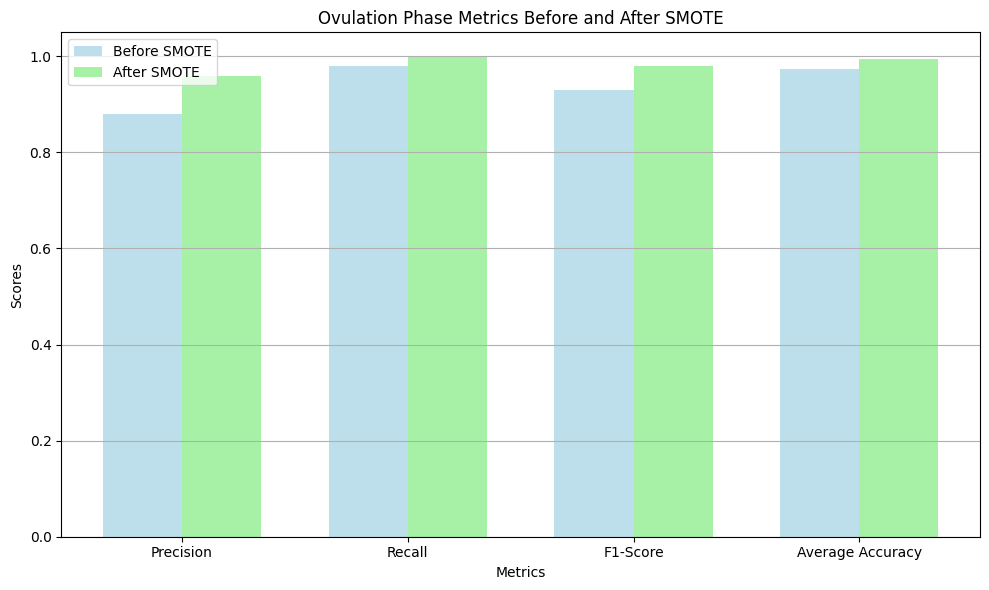

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the Ovulation phase and average accuracy
metrics = ['Precision', 'Recall', 'F1-Score', 'Average Accuracy']
before_values = [0.88, 0.98, 0.93, 0.9729]  # Before SMOTE (including average accuracy)
after_values = [0.96, 1.00, 0.98, 0.9939]    # After SMOTE (including average accuracy)

# Set up the bar width and positions
bar_width = 0.35
x = np.arange(len(metrics))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for Ovulation phase and average accuracy
ax.bar(x - bar_width/2, before_values, width=bar_width, label='Before SMOTE', color='lightblue', alpha=0.8)
ax.bar(x + bar_width/2, after_values, width=bar_width, label='After SMOTE', color='lightgreen', alpha=0.8)

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Ovulation Phase Metrics Before and After SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show grid for better readability
ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

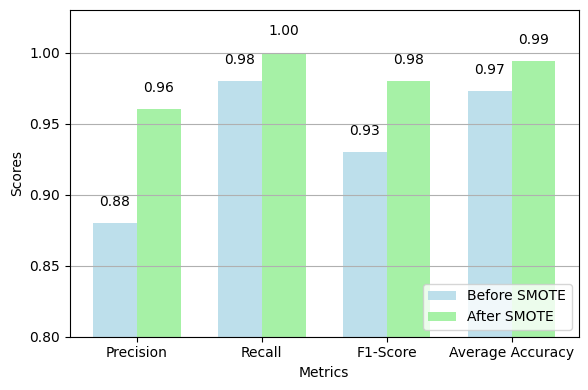

: 

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the Ovulation phase and average accuracy
metrics = ['Precision', 'Recall', 'F1-Score', 'Average Accuracy']
before_values = [0.88, 0.98, 0.93, 0.9729]  # Before SMOTE (including average accuracy)
after_values = [0.96, 1.00, 0.98, 0.9939]    # After SMOTE (including average accuracy)

# Set up the bar width and positions
bar_width = 0.35
x = np.arange(len(metrics))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Plotting the bars for Ovulation phase and average accuracy
ax.bar(x - bar_width/2, before_values, width=bar_width, label='Before SMOTE', color='lightblue', alpha=0.8)
ax.bar(x + bar_width/2, after_values, width=bar_width, label='After SMOTE', color='lightgreen', alpha=0.8)

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
# ax.set_title('Ovulation Phase Metrics Before and After SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Positioning the legend in the lower right corner
ax.legend(loc='lower right')

# Set y-axis limits to start from 0.5
ax.set_ylim(0.80, 1.03)

# Annotate each bar with its value
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, before_values[i] + 0.01, f'{before_values[i]:.2f}', ha='center', va='bottom')
    ax.text(x[i] + bar_width/2, after_values[i] + 0.01, f'{after_values[i]:.2f}', ha='center', va='bottom')

# Show grid for better readability
ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()